In [ ]:
# Importiamo le librerie necessarie
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt

# Verifichiamo se CUDA è disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Funzione per convertire le immagini in scala di grigi e ridimensionarle
def preprocess_images(images):
    images_gray = np.array([rgb2gray(img) for img in images])
    images_resized = np.array([resize(img, (64, 64)) for img in images_gray])
    images_resized = images_resized.astype('float32')
    images_resized = np.expand_dims(images_resized, axis=1)
    return images_resized

In [ ]:
# Carichiamo il dataset CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)

# Preprocessiamo le immagini
x_train = preprocess_images(train_dataset.data[:10])
x_test = preprocess_images(test_dataset.data[:10])

# Convertiamo le immagini in Tensori PyTorch
x_train = torch.from_numpy(x_train).to(device)
x_test = torch.from_numpy(x_test).to(device)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Definiamo il massimo livello di rumore
max_noise_factor = 0.5

# Funzione per aggiungere rumore Gaussiano di quantità variabile
def add_gaussian_noise(images, max_noise_factor):
    # Generiamo un fattore di rumore casuale per ogni immagine
    noise_factors = torch.rand(images.size(0), 1, 1, 1, device=images.device) * max_noise_factor
    print(f"noise_factors: {noise_factors.shape}")
    print(f"images: {images.shape}")
    noise = noise_factors * torch.randn_like(images)
    print(f"noise: {noise.shape}")
    noisy_images = images + noise
    print(f"noisy_images: {noisy_images.shape}")
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

# Aggiungiamo rumore Gaussiano di quantità variabile alle immagini
x_train_noisy = add_gaussian_noise(x_train, max_noise_factor)
x_test_noisy = add_gaussian_noise(x_test, max_noise_factor)

noise_factors: torch.Size([10, 1, 1, 1])
images: torch.Size([10, 1, 64, 64])
noise: torch.Size([10, 1, 64, 64])
noisy_images: torch.Size([10, 1, 64, 64])
noise_factors: torch.Size([10, 1, 1, 1])
images: torch.Size([10, 1, 64, 64])
noise: torch.Size([10, 1, 64, 64])
noisy_images: torch.Size([10, 1, 64, 64])


In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 64x64x32
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # 32x32x32
            nn.Conv2d(32, 16, kernel_size=3, padding=1),  # 32x32x16
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # 16x16x16
            nn.Conv2d(16, 8, kernel_size=3, padding=1),  # 16x16x8
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # 8x8x8
            nn.Conv2d(8, 4, kernel_size=3, padding=1),  # 8x8x4
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)  # 4x4x4
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 4, kernel_size=2, stride=2),  # 8x8x4
            nn.ReLU(),
            nn.ConvTranspose2d(4, 8, kernel_size=2, stride=2),  # 16x16x8
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),  # 32x32x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2),  # 64x64x32
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),  # 64x64x1
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Inizializziamo il modello, la loss function e l'optimizer
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Definiamo il numero di epoche
num_epochs = 100
batch_size = 2

# Creiamo i DataLoader
train_dataset = torch.utils.data.TensorDataset(x_train_noisy, x_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(x_test_noisy, x_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Liste per tenere traccia della loss
train_loss_list = []
val_loss_list = []

In [ ]:
# Loop di addestramento
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, targets = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_list.append(epoch_loss)

    # Validazione
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
    val_epoch_loss = val_running_loss / len(test_loader.dataset)
    val_loss_list.append(val_epoch_loss)

    print(f'Epoca {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')

Epoca 1/1000, Loss: 0.0177, Val Loss: 0.0163
Epoca 2/1000, Loss: 0.0176, Val Loss: 0.0158
Epoca 3/1000, Loss: 0.0173, Val Loss: 0.0160
Epoca 4/1000, Loss: 0.0174, Val Loss: 0.0158
Epoca 5/1000, Loss: 0.0170, Val Loss: 0.0159
Epoca 6/1000, Loss: 0.0170, Val Loss: 0.0158
Epoca 7/1000, Loss: 0.0170, Val Loss: 0.0158
Epoca 8/1000, Loss: 0.0169, Val Loss: 0.0156
Epoca 9/1000, Loss: 0.0169, Val Loss: 0.0156
Epoca 10/1000, Loss: 0.0168, Val Loss: 0.0158
Epoca 11/1000, Loss: 0.0168, Val Loss: 0.0157
Epoca 12/1000, Loss: 0.0167, Val Loss: 0.0155
Epoca 13/1000, Loss: 0.0167, Val Loss: 0.0155
Epoca 14/1000, Loss: 0.0166, Val Loss: 0.0158
Epoca 15/1000, Loss: 0.0168, Val Loss: 0.0155
Epoca 16/1000, Loss: 0.0165, Val Loss: 0.0152
Epoca 17/1000, Loss: 0.0165, Val Loss: 0.0158
Epoca 18/1000, Loss: 0.0166, Val Loss: 0.0156
Epoca 19/1000, Loss: 0.0167, Val Loss: 0.0158
Epoca 20/1000, Loss: 0.0168, Val Loss: 0.0158
Epoca 21/1000, Loss: 0.0169, Val Loss: 0.0155
Epoca 22/1000, Loss: 0.0171, Val Loss: 0.01

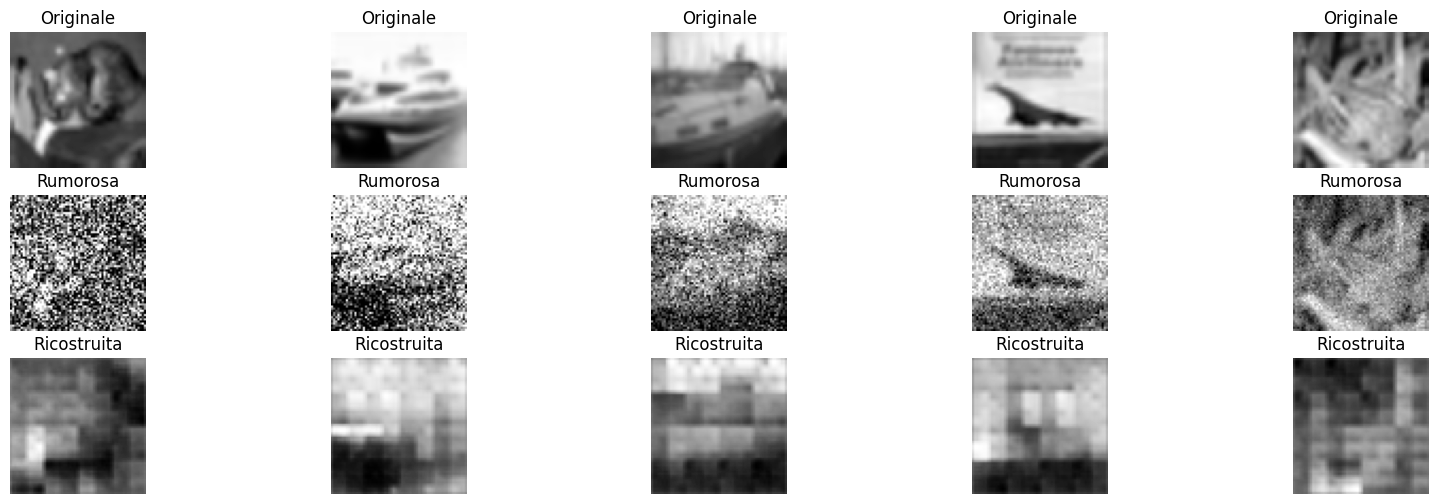

In [ ]:
# Ricostruzione delle immagini
model.eval()
with torch.no_grad():
    decoded_imgs = model(x_test_noisy).cpu().numpy()

# Convertiamo le immagini in NumPy array
x_test_noisy_np = x_test_noisy.cpu().numpy()
x_test_np = x_test.cpu().numpy()

# Visualizzazione
n = 5
plt.figure(figsize=(20, 6))
for i in range(n):
    # Immagini originali
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_np[i].reshape(64, 64), cmap='gray')
    plt.title("Originale")
    plt.axis('off')

    # Immagini rumorose
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy_np[i].reshape(64, 64), cmap='gray')
    plt.title("Rumorosa")
    plt.axis('off')

    # Immagini ricostruite
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(64, 64), cmap='gray')
    plt.title("Ricostruita")
    plt.axis('off')
plt.show()


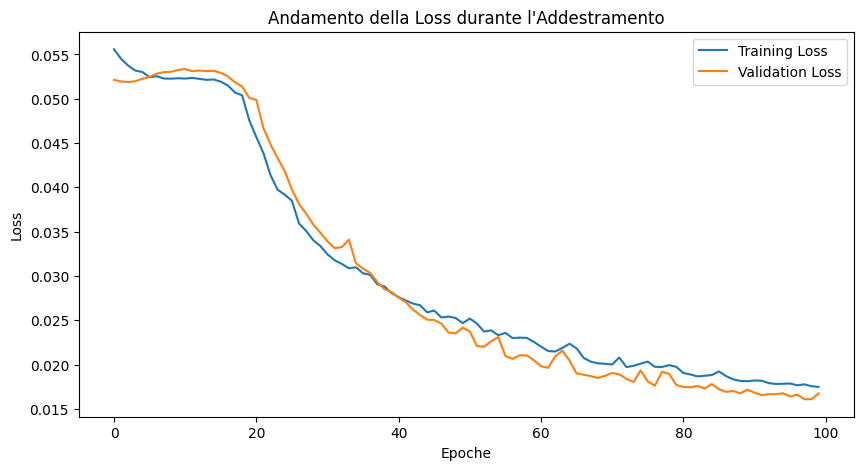

In [ ]:
# Plot della loss
plt.figure(figsize=(10,5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Andamento della Loss durante l\'Addestramento')
plt.ylabel('Loss')
plt.xlabel('Epoche')
plt.legend()
plt.show()

In [ ]:
print("Valori min e max delle immagini originali:")
print(f"Min: {x_train.min()}, Max: {x_train.max()}")

print("Valori min e max delle immagini rumorose:")
print(f"Min: {x_train_noisy.min()}, Max: {x_train_noisy.max()}")


Valori min e max delle immagini originali:
Min: 0.005359803792089224, Max: 1.0
Valori min e max delle immagini rumorose:
Min: 0.0, Max: 1.0


In [ ]:
# Caricamento del dataset CIFAR-10
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset_full = datasets.CIFAR10(root='./data', train=False, download=True)


print("Valori min e max delle immagini raw:")
print(f"Min: {train_dataset_full.data.min()}, Max: {train_dataset_full.data.max()}")


Files already downloaded and verified
Files already downloaded and verified
Valori min e max delle immagini raw:
Min: 0, Max: 255
